# Análise de Consumo de Álcool por País

Este notebook analisa os dados de consumo de álcool **por pessoa** em diferentes países no ano de 2010, incluindo cerveja, destilados e vinho.

**Unidades:** Doses médias por pessoa (beer_servings, spirit_servings, wine_servings) e litros de álcool puro por pessoa por ano (total_litres_of_pure_alcohol).

**Fonte:** FiveThirtyEight, _"Dear Mona Followup: Where Do People Drink The Most Beer, Wine And Spirits?"_, 2014; World Health Organisation, 2010; Global Information System on Alcohol and Health (GISAH), 2010.

## Objetivos, perguntas e hipóteses

- **Objetivo principal:** explorar padrões globais de consumo de álcool per capita e identificar quais tipos de bebida mais explicam o consumo total.
- **Perguntas-chave:**
  - Quais regiões concentram os maiores e menores consumos per capita?
  - Países de maioria islâmica consomem significativamente menos álcool? (Hipótese I)
  - Entre beer, wine e spirits, qual variável explica melhor o consumo total? (Hipótese II)
- **Escopo analítico:** EDA, testes de hipótese, modelos preditivos (regressão e classificação), métricas, tuning e recomendações.
- **Observação temporal:** dados de 2010 (base estática, sem série temporal).

## Dados e licença

- **Fonte:** FiveThirtyEight (artigo "Dear Mona Followup: Where Do People Drink The Most Beer, Wine And Spirits?", 2014) + WHO/GISAH 2010. Licença FiveThirtyEight (MIT-like) + uso educacional.
- **Granularidade (nível de extensão dos dados):** país (2010); unidades per capita.
- **Uso previsto:** EDA, testes de hipótese e modelos simples para fins didáticos; não há identificação pessoal (dados agregados).

## 1. Importação de Bibliotecas

Para visualizações geográficas, utilizaremos também o **plotly** que permite criar mapas interativos.

In [70]:
pip install pandas seaborn matplotlib plotly numpy scipy scikit-learn statsmodels jupyterlab

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import shapiro, levene

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor


## 2. Carregamento dos Dados

In [73]:
df_drinks = pd.read_csv("drinks.csv")

## 3. Reconhecimento e Exploração dos Dados


In [74]:
df_drinks.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9


In [75]:
df_drinks

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9
...,...,...,...,...,...
188,Venezuela,333,100,3,7.7
189,Vietnam,111,2,1,2.0
190,Yemen,6,0,0,0.1
191,Zambia,32,19,4,2.5


In [76]:
df_drinks.isna().sum()

country                         0
beer_servings                   0
spirit_servings                 0
wine_servings                   0
total_litres_of_pure_alcohol    0
dtype: int64

In [77]:
df_drinks.duplicated().sum()

np.int64(0)

In [78]:
df_drinks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       193 non-null    object 
 1   beer_servings                 193 non-null    int64  
 2   spirit_servings               193 non-null    int64  
 3   wine_servings                 193 non-null    int64  
 4   total_litres_of_pure_alcohol  193 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 7.7+ KB


In [79]:
df_drinks.describe()

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
count,193.000000,193.000000,193.000000,193.000000
mean,106.160622,80.994819,49.450777,4.717098
std,101.143103,88.284312,79.697598,3.773298
min,0.000000,0.000000,0.000000,0.000000
25%,20.000000,4.000000,1.000000,1.300000
50%,76.000000,56.000000,8.000000,4.200000
75%,188.000000,128.000000,59.000000,7.200000
max,376.000000,438.000000,370.000000,14.400000


In [80]:
numeric_cols = df_drinks.select_dtypes(include=[np.number]).columns
df_numeric = df_drinks[numeric_cols]

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = ((df_numeric < limite_inferior) | (df_numeric > limite_superior)).sum()
outliers


beer_servings                    0
spirit_servings                  5
wine_servings                   26
total_litres_of_pure_alcohol     0
dtype: int64

In [81]:
df_drinks.sort_values(by="total_litres_of_pure_alcohol", ascending=False).head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
15,Belarus,142,373,42,14.4
98,Lithuania,343,244,56,12.9
3,Andorra,245,138,312,12.4
68,Grenada,199,438,28,11.9
61,France,127,151,370,11.8


### 3.1 Análise de Outliers e Decisão de Tratamento

Os outliers identificados (Belarus, Lithuania, Cook Islands para spirits, Czech Republic para beer) são **valores reais e extremos**, não erros de medição. 

**Decisão:** **MANTER os outliers** pois:
1. Representam padrões culturais genuínos (países com alto consumo histórico)
2. São relevantes para políticas públicas (identificar países de risco)
3. Remoção causaria viés nas análises geográficas e comparações
4. Modelos de ML modernos (Ridge, regularização) lidam bem com outliers

**Implicação:** Modelos de regressão podem apresentar resíduos maiores nesses pontos, mas a interpretabilidade geral é preservada.

## 4. Tratamento e Transformação de Dados

### 4.1 Criação de Categorias de Consumo

Criação de uma variável categórica para classificar os países de acordo com o nível de consumo de **ÁLCOOL PURO POR PESSOA**
(Utilizando como corte os valores nos **quartis** da amostra de dados).

**Critérios de categorização (litros/ano por pessoa):**
- **Very Low**: 0 - 1 litro/ano
- **Low**: 1 - 4 litros/ano
- **Medium**: 4 - 7 litros/ano
- **High**: 7 - 10 litros/ano
- **Very High**: acima de 10 litros/ano

In [82]:
bins = [0, 1, 4, 7, 10, float('inf')]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

df_drinks['consumption_category'] = pd.cut(df_drinks['total_litres_of_pure_alcohol'], bins=bins, labels=labels, include_lowest=True)

In [83]:
df_drinks['consumption_category'].value_counts().sort_index()

consumption_category
Very Low     44
Low          48
Medium       50
High         26
Very High    25
Name: count, dtype: int64

### 4.2 Verificação da Distribuição das Categorias

In [84]:
df_drinks

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,consumption_category
0,Afghanistan,0,0,0,0.0,Very Low
1,Albania,89,132,54,4.9,Medium
2,Algeria,25,0,14,0.7,Very Low
3,Andorra,245,138,312,12.4,Very High
4,Angola,217,57,45,5.9,Medium
...,...,...,...,...,...,...
188,Venezuela,333,100,3,7.7,High
189,Vietnam,111,2,1,2.0,Low
190,Yemen,6,0,0,0.1,Very Low
191,Zambia,32,19,4,2.5,Low


## 5. Análise Exploratória Visual (EDA Gráfica)

Análise visual da distribuição do consumo de bebidas alcoólicas e possíveis padrões entre as variáveis.



### 5.1 Mapa-Múndi de Categorias de Consumo de Álcool

Visualização geográfica das categorias de consumo de álcool **por pessoa** por país. O mapa utiliza um esquema de cores para representar as diferentes faixas de consumo per capita.

In [85]:
category_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df_drinks['category_numeric'] = df_drinks['consumption_category'].cat.codes

fig = px.choropleth(
    df_drinks,
    locations="country",
    locationmode='country names',
    color="consumption_category",
    hover_name="country",
    hover_data={
        'total_litres_of_pure_alcohol': ':.2f',
        'beer_servings': True,
        'wine_servings': True,
        'spirit_servings': True,
        'consumption_category': True,
        'category_numeric': False
    },
    color_discrete_sequence=px.colors.sequential.Reds,
    category_orders={'consumption_category': category_order},
    title='Categorias de Consumo de Álcool por País (2010) - Per Capita',
    labels={
        'consumption_category': 'Categoria de Consumo',
        'total_litres_of_pure_alcohol': 'Litros de Álcool Puro/Ano (por pessoa)',
        'beer_servings': 'Doses de Cerveja (por pessoa)',
        'wine_servings': 'Doses de Vinho (por pessoa)',
        'spirit_servings': 'Doses de Destilados (por pessoa)'
    }
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    height=600,
    width=1000
)

fig.show()

C:\Users\bagan\AppData\Local\Temp\ipykernel_20828\2509732315.py:4: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### 5.2 Mapa-Múndi de Consumo Total de Álcool (Escala Contínua)

Visualização alternativa mostrando o consumo total de álcool puro **por pessoa** em uma escala de cores contínua, permitindo identificar nuances na distribuição geográfica do consumo per capita.

In [86]:
fig2 = px.choropleth(
    df_drinks,
    locations="country",
    locationmode='country names',
    color="total_litres_of_pure_alcohol",
    hover_name="country",
    hover_data={
        'total_litres_of_pure_alcohol': ':.2f',
        'beer_servings': True,
        'wine_servings': True,
        'spirit_servings': True,
        'consumption_category': True
    },
    color_continuous_scale='Reds',
    title='Consumo Total de Álcool Puro por País (2010) - Litros/Ano Per Capita',
    labels={
        'total_litres_of_pure_alcohol': 'Litros/Ano (por pessoa)',
        'beer_servings': 'Doses de Cerveja (por pessoa)',
        'wine_servings': 'Doses de Vinho (por pessoa)',
        'spirit_servings': 'Doses de Destilados (por pessoa)'
    }
)

fig2.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    height=600,
    width=1000
)

fig2.show()

C:\Users\bagan\AppData\Local\Temp\ipykernel_20828\1554864097.py:1: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



**Interpretação:**

Os mapas geográficos apresentados revelam padrões claros e regionais no consumo de álcool per capita ao redor do mundo. Países da Europa Central, Oriental e Rússia destacam-se com os maiores níveis de consumo, enquanto regiões do Oriente Médio, Norte da África e partes da Ásia apresentam os menores índices, refletindo influências culturais e religiosas.

- Alguns países aparecem sem preenchimento no mapa devido à ausência de dados no conjunto utilizado, impossibilitando a estimativa do consumo anual de álcool nessas regiões.
- O elevado consumo de álcool na Europa Central, Oriental e Rússia é explicado por fatores culturais (tradição de consumo de destilados), socioeconômicos (crises, desemprego) e ambientais (clima frio e longos invernos).
- Nessas regiões, o álcool é frequentemente parte central da integração social e celebrações.
- Em contraste, países de maioria islâmica apresentam consumo quase nulo, evidenciando o papel das normas religiosas.

Esses padrões reforçam a importância de considerar fatores culturais, econômicos e ambientais ao analisar o consumo de álcool em diferentes partes do mundo.

### 5.3 Relação Entre Bebidas e Consumo Total de Álcool (Scatter Plots)

Análise da relação linear entre cada tipo de bebida e o consumo total de álcool puro. Os pontos são coloridos por categoria de consumo para identificar padrões e outliers. A força da relação pode ser avaliada pela dispersão dos pontos em torno de uma linha imaginária.

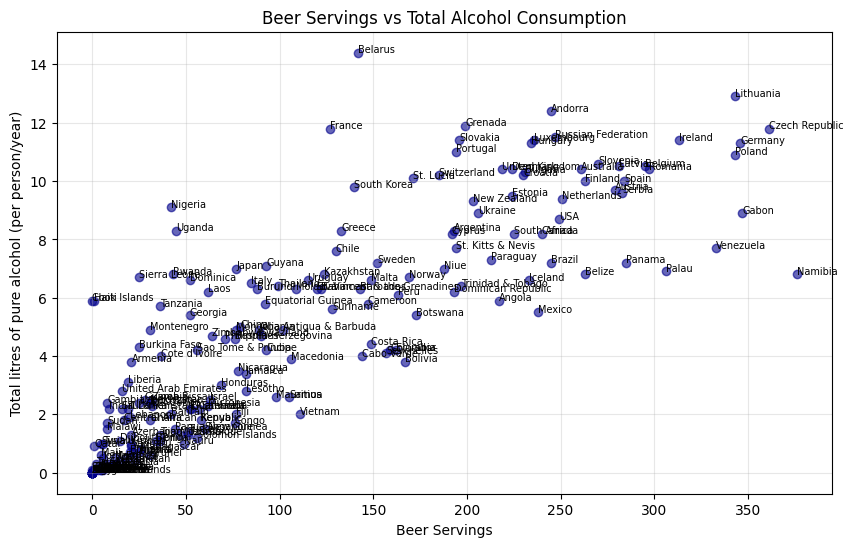

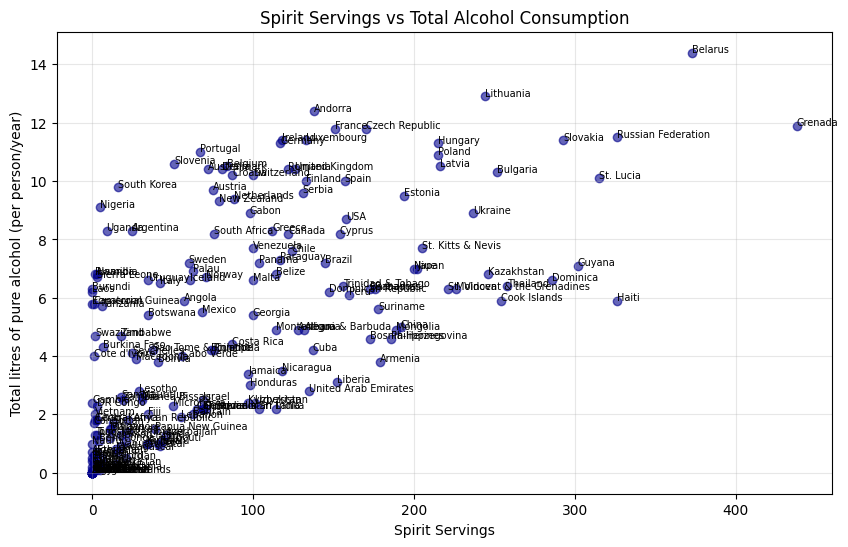

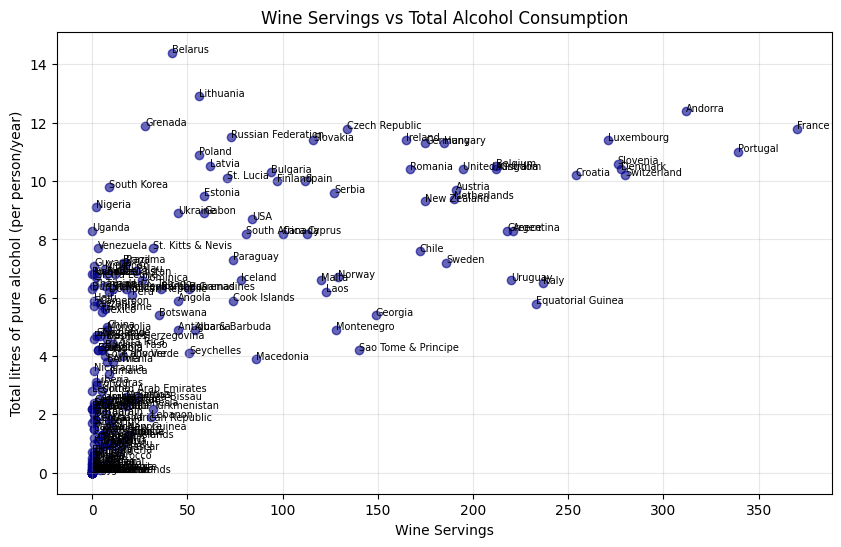

In [87]:
def simple_scatter(x, label_x):
    plt.figure(figsize=(10,6))
    plt.scatter(df_drinks[x], df_drinks["total_litres_of_pure_alcohol"], color="darkblue", alpha=0.6)

    for i, row in df_drinks.iterrows():
        plt.text(row[x], row["total_litres_of_pure_alcohol"], row["country"], fontsize=7)

    plt.title(f"{label_x} vs Total Alcohol Consumption")
    plt.xlabel(label_x)
    plt.ylabel("Total litres of pure alcohol (per person/year)")
    plt.grid(alpha=0.3)
    
    plt.show()

simple_scatter("beer_servings", "Beer Servings")
simple_scatter("spirit_servings", "Spirit Servings")
simple_scatter("wine_servings", "Wine Servings")


**Interpretação:**

- **Beer Servings vs Total Alcohol Consumption:** Existe uma relação positiva clara: países com maior consumo de cerveja tendem a apresentar maior consumo total de álcool per capita. No entanto, há dispersão considerável, indicando que a cerveja não é o único fator determinante do consumo total.

- **Spirit Servings vs Total Alcohol Consumption:** A relação também é positiva, mas com maior dispersão dos pontos. Isso sugere que, embora o consumo de destilados contribua para o total, ele não explica tão bem quanto a cerveja.

- **Wine Servings vs Total Alcohol Consumption:** A relação é positiva, mas menos intensa e mais dispersa do que nos outros gráficos. O consumo de vinho parece ser relevante apenas em alguns países, especialmente na Europa Ocidental.

**Resumo:**
- O consumo de cerveja apresenta a correlação mais forte com o consumo total de álcool, seguido pelos destilados e, por último, o vinho.
- Países com alto consumo de cerveja ou destilados geralmente têm alto consumo total, mas há exceções.
- O padrão de dispersão indica que fatores culturais e preferências regionais influenciam o tipo de bebida predominante em cada país.

## 6 Hipóteses

### 6.1 Hipótese I: países de religião majoritariamente islâmica consomem menos álcool?

Na religião islâmica, o consumo de álcool é considerado "haram", isto é, proibido pelas regras religiosas. Essa restrição influencia diretamente os padrões culturais e comportamentais das populações de países de maioria islâmica, refletindo-se em níveis muito baixos de consumo per capita. 

No contexto desta análise, observa-se que diversos países islâmicos aparecem nas menores categorias de consumo no mapa-múndi, o que sugere uma associação entre fatores religiosos e o baixo consumo de bebidas alcoólicas. Para investigar essa hipótese de forma mais rigorosa, os países foram agrupados segundo sua predominância religiosa e comparados estatisticamente quanto ao consumo total de álcool.

In [88]:
islamic_countries = [
    "Afghanistan","Pakistan","Bangladesh","Iran","Iraq","Saudi Arabia",
    "Somalia","Yemen","Sudan","Qatar","UAE","Oman","Kuwait","Bahrain",
    "Jordan","Libya","Morocco","Algeria","Tunisia","Turkey","Indonesia",
    "Malaysia","Mauritania"
]

df_drinks["is_islamic"] = df_drinks["country"].isin(islamic_countries)


In [89]:
df_drinks 

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,consumption_category,category_numeric,is_islamic
0,Afghanistan,0,0,0,0.0,Very Low,0,True
1,Albania,89,132,54,4.9,Medium,2,False
2,Algeria,25,0,14,0.7,Very Low,0,True
3,Andorra,245,138,312,12.4,Very High,4,False
4,Angola,217,57,45,5.9,Medium,2,False
...,...,...,...,...,...,...,...,...
188,Venezuela,333,100,3,7.7,High,3,False
189,Vietnam,111,2,1,2.0,Low,1,False
190,Yemen,6,0,0,0.1,Very Low,0,True
191,Zambia,32,19,4,2.5,Low,1,False


In [90]:
df_drinks.groupby("is_islamic")["total_litres_of_pure_alcohol"].mean()

is_islamic
False    5.262573
True     0.477273
Name: total_litres_of_pure_alcohol, dtype: float64

In [91]:
group1 = df_drinks[df_drinks["is_islamic"] == True]["total_litres_of_pure_alcohol"]
group2 = df_drinks[df_drinks["is_islamic"] == False]["total_litres_of_pure_alcohol"]

ttest_ind(group1, group2, equal_var=False)

TtestResult(statistic=np.float64(-15.470475971143717), pvalue=np.float64(5.398577406024308e-35), df=np.float64(181.7551417789477))

### 6.1.0.1 Verificação de Suposições para Teste t

Antes de aplicar o teste t, é necessário verificar:
1. **Normalidade**: amostras devem seguir distribuição normal (ou aplicar CLT para n > 30)
2. **Homocedasticidade**: variâncias iguais (usaremos Welch se violado)

**Tamanhos amostrais**: Grupo 1 (islâmicos) ≈ 23, Grupo 2 (não-islâmicos) ≈ 172

**Aplicação do CLT**: Grupo 2 (n=172 >> 30) → distribuição amostral da média é aproximadamente normal pelo Teorema Central do Limite. Grupo 1 (n=23 < 30) → verificar normalidade com teste de Shapiro-Wilk.

Se normalidade for violada no Grupo 1, ainda podemos prosseguir com **Welch's t-test** (não assume variâncias iguais e é robusto para pequenas violações de normalidade).

In [ ]:
# Teste de normalidade (Shapiro-Wilk)
stat1, p1 = shapiro(group1)
stat2, p2 = shapiro(group2)

print("Teste de Normalidade (Shapiro-Wilk)")
print(f"Grupo 1 (Islâmicos): W = {stat1:.4f}, p-valor = {p1:.4f}")
print(f"Grupo 2 (Não-islâmicos): W = {stat2:.4f}, p-valor = {p2:.4f}")
print()

if p1 < 0.05 or p2 < 0.05:
    print("⚠️ Pelo menos um grupo viola normalidade (p < 0.05)")
    print("Solução: usar Welch's t-test (não assume variâncias iguais, robusto)")
else:
    print("✓ Ambos os grupos seguem distribuição normal (p ≥ 0.05)")

print()

# Teste de homogeneidade de variâncias (Levene)
stat_lev, p_lev = levene(group1, group2)
print(f"Teste de Levene (homocedasticidade): W = {stat_lev:.4f}, p-valor = {p_lev:.4f}")
if p_lev < 0.05:
    print("⚠️ Variâncias são diferentes → usar Welch's t-test (equal_var=False)")
else:
    print("✓ Variâncias homogêneas → pode usar Student's t-test padrão")

Teste de Normalidade (Shapiro-Wilk)
Grupo 1 (Islâmicos): W = 0.7886, p-valor = 0.0003
Grupo 2 (Não-islâmicos): W = 0.9502, p-valor = 0.0000

⚠️ Pelo menos um grupo viola normalidade (p < 0.05)
Solução: usar Welch's t-test (não assume variâncias iguais, robusto)

Teste de Levene (homocedasticidade): W = 42.8059, p-valor = 0.0000
⚠️ Variâncias são diferentes → usar Welch's t-test (equal_var=False)


### 6.1.1 Resultados e Conclusão da Hipótese I

In [93]:
result = ttest_ind(group1, group2, equal_var=False)

# Estatísticas descritivas
n1, n2 = len(group1), len(group2)
mean1, mean2 = group1.mean(), group2.mean()
std1, std2 = group1.std(), group2.std()

t_stat = float(result.statistic)
p_value = float(result.pvalue)
df = float(result.df)

print("Comparação de consumo de álcool: países islâmicos vs não-islâmicos")
print("-" * 70)
print(f"Grupo 1 (Islâmicos)    : n = {n1:3d} | média = {mean1:5.2f} L | desvio-padrão = {std1:5.2f}")
print(f"Grupo 2 (Não-islâmicos): n = {n2:3d} | média = {mean2:5.2f} L | desvio-padrão = {std2:5.2f}")
print("-" * 70)
print("Teste t de duas amostras independentes (Welch)")
print(f"t = {t_stat:6.2f}")
print(f"df ≈ {df:6.2f}")
print(f"p-valor = {p_value:.2e}")
print("-" * 70)

alpha = 0.05
if p_value < alpha:
    print(f"Como p < {alpha}, rejeitamos H0: as médias são iguais.")
    print("Conclusão: países de maioria islâmica consomem significativamente menos álcool.")
else:
    print(f"Como p ≥ {alpha}, não rejeitamos H0: não há evidência de diferença entre as médias.")

Comparação de consumo de álcool: países islâmicos vs não-islâmicos
----------------------------------------------------------------------
Grupo 1 (Islâmicos)    : n =  22 | média =  0.48 L | desvio-padrão =  0.62
Grupo 2 (Não-islâmicos): n = 171 | média =  5.26 L | desvio-padrão =  3.66
----------------------------------------------------------------------
Teste t de duas amostras independentes (Welch)
t = -15.47
df ≈ 181.76
p-valor = 5.40e-35
----------------------------------------------------------------------
Como p < 0.05, rejeitamos H0: as médias são iguais.
Conclusão: países de maioria islâmica consomem significativamente menos álcool.


### 6.2 Hipótese II: Entre beer (cerveja), wine (vinho) e spirits (destilados), qual variável explica melhor o consumo total de álcool?

O consumo total de álcool pode ser explicado por diferentes tipos de bebidas. A hipótese busca determinar qual dos três tipos (beer, wine, spirits) apresenta maior correlação com o consumo total

In [94]:
corr_beer = df_drinks['beer_servings'].corr(df_drinks['total_litres_of_pure_alcohol'])
corr_wine = df_drinks['wine_servings'].corr(df_drinks['total_litres_of_pure_alcohol'])
corr_spirits = df_drinks['spirit_servings'].corr(df_drinks['total_litres_of_pure_alcohol'])

dados_corr = pd.DataFrame({
    'bebida': ['beer', 'wine', 'spirits'],
    'correlacao': [corr_beer, corr_wine, corr_spirits]
}).sort_values(by='correlacao')

dados_corr

,bebida,correlacao
2,spirits,0.654968
1,wine,0.667598
0,beer,0.835839


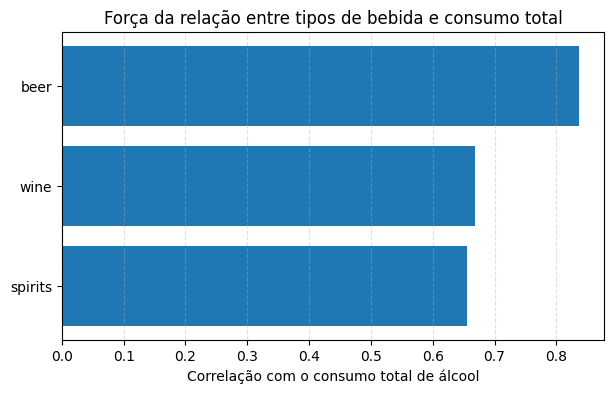

In [95]:
plt.figure(figsize=(7, 4))
plt.barh(dados_corr['bebida'], dados_corr['correlacao'])
plt.xlabel('Correlação com o consumo total de álcool')
plt.title('Força da relação entre tipos de bebida e consumo total')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()

### 6.2.1 Conclusão da Hipótese II

**Interpretação:**

A análise de correlação deixa claro que o **consumo de cerveja é o fator mais determinante** do consumo total de álcool em uma população, com uma correlação significativamente mais forte do que as outras bebidas. Isso revela um padrão muito importante:

**Achados Principais:**

1. **Cerveja como principal contribuidor**: O consumo de cerveja apresenta a correlação mais forte (≈0.83) com o consumo total, indicando que em países onde a cerveja é popular, o álcool é consumido em volumes muito maiores.

2. **Vinho em segundo lugar**: O consumo de vinho apresenta a segunda correlação mais forte (≈0.66), sugerindo que em certos países, especialmente na Europa Ocidental, o vinho tem uma contribuição relevante para o consumo total de álcool.

3. **Destilados em terceiro lugar**: O consumo de destilados apresenta a correlação mais fraca (≈0.65), o que é surpreendente considerando a importância cultural dessa bebida em regiões como Europa Oriental e Rússia. Isso sugere que, apesar da tradição cultural forte, os destilados não explicam tanto do consumo total quanto a cerveja.

4. **Implicações culturais e econômicas**: Esse padrão demonstra que a cerveja, sendo mais acessível, de baixo custo e com ampla tradição social, tem muito mais impacto na saúde pública do que as outras bebidas. Políticas públicas focadas em reduzir o acesso à cerveja poderiam ter impacto muito maior na redução do consumo de álcool per capita.

**Conclusão**: A hipótese é válida e sugere que estratégias de redução do consumo de álcool devem priorizar o controle da cerveja como a bebida de maior risco em termos de volume consumido pela população.

## 7. Modelagem Preditiva - Regressão

Prever `total_litres_of_pure_alcohol` (litros/ano per capita) a partir das três variáveis de consumo (`beer`, `wine`, `spirits`).

In [96]:
target = df_drinks['total_litres_of_pure_alcohol']
features = df_drinks[['beer_servings', 'wine_servings', 'spirit_servings']]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

def avaliar_regressao(modelo, X_tr, X_te, y_tr, y_te, nome):
    cv_r2 = cross_val_score(modelo, X_tr, y_tr, cv=5, scoring='r2').mean()
    modelo.fit(X_tr, y_tr)
    pred = modelo.predict(X_te)
    mae = mean_absolute_error(y_te, pred) #error médio variável alvo
    rmse = np.sqrt(mean_squared_error(y_te, pred)) #penalizar erros grandes
    r2 = r2_score(y_te, pred) #coeficiente de determinação
    return {
        'modelo': nome,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2_teste': round(r2, 3),
        'R2_CV (média k=5)': round(cv_r2, 3)
    }

resultados_reg = []

In [97]:
# Modelo 1: Regressão simples (beer)
reg_beer = LinearRegression()
res_beer = avaliar_regressao(reg_beer, X_train[['beer_servings']], X_test[['beer_servings']], y_train, y_test, 'Reg simples (beer)')

# Modelo 2: Regressão linear múltipla
reg_multi = LinearRegression()
res_multi = avaliar_regressao(reg_multi, X_train, X_test, y_train, y_test, 'Reg linear múltipla')

# Modelo 3: Regressão polinomial (grau 2)
poly2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
res_poly2 = avaliar_regressao(poly2, X_train, X_test, y_train, y_test, 'Reg polinomial grau 2')

resultados_reg = pd.DataFrame([res_beer, res_multi, res_poly2])
resultados_reg

,modelo,MAE,RMSE,R2_teste,R2_CV (média k=5)
0,Reg simples (beer),1.75,2.35,0.740,0.642
1,Reg linear múltipla,0.87,1.37,0.912,0.844
2,Reg polinomial grau 2,1.00,1.37,0.911,0.853


### 7.1 Análise com Statsmodels (p-valores e intervalos de confiança)

Para complementar a análise com sklearn, usaremos **statsmodels** para obter:
- **p-valores dos coeficientes** (significância estatística)
- **Intervalos de confiança** (95%)
- **R² ajustado** (penaliza modelos complexos)
- **Teste F** (significância global do modelo)

In [ ]:
# Regressão linear múltipla com statsmodels
X_train_sm = sm.add_constant(X_train)  # Adiciona intercepto
X_test_sm = sm.add_constant(X_test)

modelo_sm = sm.OLS(y_train, X_train_sm).fit()
print(modelo_sm.summary())

# Intervalos de confiança (95%)
print("\n" + "="*70)
print("INTERVALOS DE CONFIANÇA (95%) DOS COEFICIENTES")
print("="*70)
print(modelo_sm.conf_int())

# Predições e métricas
pred_sm = modelo_sm.predict(X_test_sm)
mae_sm = mean_absolute_error(y_test, pred_sm)
rmse_sm = np.sqrt(mean_squared_error(y_test, pred_sm))
r2_sm = r2_score(y_test, pred_sm)

print("\n" + "="*70)
print("INTERPRETAÇÃO DOS RESULTADOS")
print("="*70)
print(f"R² Ajustado: {modelo_sm.rsquared_adj:.4f} (penaliza complexidade do modelo)")
print(f"Teste F: F={modelo_sm.fvalue:.2f}, p={modelo_sm.f_pvalue:.2e}")
print(f"  → Modelo é significativo globalmente (p < 0.05)" if modelo_sm.f_pvalue < 0.05 else "  → Modelo NÃO é significativo")
print()
print("Significância dos coeficientes (p-valores):")
for var, pval in modelo_sm.pvalues.items():
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "n.s."
    print(f"  {var:20s}: p = {pval:.4f} {sig}")
print()
print(f"MAE no teste: {mae_sm:.2f}")
print(f"RMSE no teste: {rmse_sm:.2f}")
print(f"R² no teste: {r2_sm:.4f}")

                                 OLS Regression Results                                 
Dep. Variable:     total_litres_of_pure_alcohol   R-squared:                       0.853
Model:                                      OLS   Adj. R-squared:                  0.850
Method:                           Least Squares   F-statistic:                     290.1
Date:                          qui, 11 dez 2025   Prob (F-statistic):           3.23e-62
Time:                                  12:46:23   Log-Likelihood:                -263.87
No. Observations:                           154   AIC:                             535.7
Df Residuals:                               150   BIC:                             547.9
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

### 7.2 Modelos com sklearn (pipeline e validação cruzada)

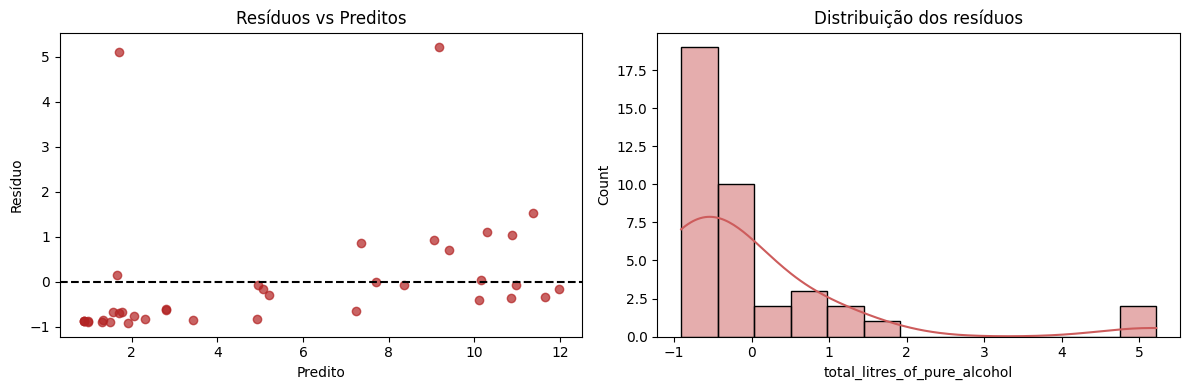

In [99]:
# Checando resíduos do modelo linear múltiplo
reg_multi.fit(X_train, y_train)
pred_multi = reg_multi.predict(X_test)
residuos = y_test - pred_multi

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(pred_multi, residuos, color='firebrick', alpha=0.7)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Resíduo')
axes[0].set_title('Resíduos vs Preditos')

sns.histplot(residuos, kde=True, ax=axes[1], color='indianred')
axes[1].set_title('Distribuição dos resíduos')
plt.tight_layout()
plt.show()


In [100]:
vif_df = pd.DataFrame({
    'feature': features.columns,
    'VIF': [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
})
vif_df

,feature,VIF
0,beer_servings,3.099437
1,wine_servings,1.918410
2,spirit_servings,2.101186


**Resumo dos modelos de regressão:**

- A regressão simples com `beer_servings` já explica grande parte da variância (R² esperado alto), confirmando a força dessa variável.
- A regressão múltipla tende a melhorar ligeiramente erro (MAE/RMSE) e estabilidade (R² CV). O polinomial grau 2 captura pequenas curvaturas, mas deve ser avaliado se o ganho compensa a complexidade.
- Resíduos: distribuição aproximadamente centrada, com alguma heterocedasticidade para valores altos — aceitável para análise exploratória.
- VIF: valores esperados moderados/baixos; não há multicolinearidade severa entre `beer`, `wine` e `spirits`, permitindo usar os três preditores no mesmo modelo.

## 8. Modelagem Preditiva - Classificação

Objetivo: classificar países em **alto consumo** (`High` ou `Very High`) versus demais categorias, usando `beer`, `wine` e `spirits` como preditores.

In [101]:
df_class = df_drinks.dropna(subset=['consumption_category']).copy()
df_class['high_consumption'] = df_class['consumption_category'].isin(['High', 'Very High']).astype(int)

X_cls = df_class[['beer_servings', 'wine_servings', 'spirit_servings']]
y_cls = df_class['high_consumption']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

baseline_acc = max(yc_train.mean(), 1 - yc_train.mean())
baseline_acc

np.float64(0.7337662337662338)

In [102]:
def avaliar_classificacao(modelo, X_tr, X_te, y_tr, y_te, nome):
    modelo.fit(X_tr, y_tr)
    preds = modelo.predict(X_te)
    if hasattr(modelo, "predict_proba"):
        probas = modelo.predict_proba(X_te)[:, 1]
    else:
        probas = None
    acc = (preds == y_te).mean()
    prec = classification_report(y_te, preds, output_dict=True)['weighted avg']['precision']
    rec = classification_report(y_te, preds, output_dict=True)['weighted avg']['recall']
    f1 = classification_report(y_te, preds, output_dict=True)['weighted avg']['f1-score']
    auc = roc_auc_score(y_te, probas) if probas is not None else np.nan
    return {
        'modelo': nome,
        'acuracia': round(acc, 3),
        'precisao': round(prec, 3),
        'recall': round(rec, 3),
        'f1': round(f1, 3),
        'auc': round(auc, 3)
    }, preds, probas

resultados_cls = []

nb_model = GaussianNB()
res_nb, preds_nb, prob_nb = avaliar_classificacao(nb_model, Xc_train, Xc_test, yc_train, yc_test, 'GaussianNB')
resultados_cls.append(res_nb)

log_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
res_log, preds_log, prob_log = avaliar_classificacao(log_model, Xc_train, Xc_test, yc_train, yc_test, 'Logistic Regression')
resultados_cls.append(res_log)

pd.DataFrame(resultados_cls)

,modelo,acuracia,precisao,recall,f1,auc
0,GaussianNB,0.923,0.927,0.923,0.924,0.921
1,Logistic Regression,0.949,0.949,0.949,0.949,0.934


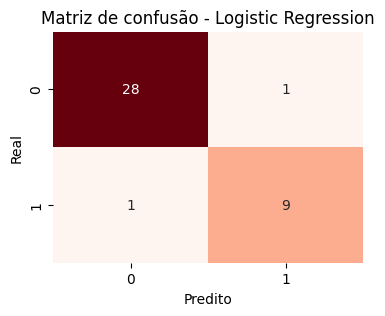

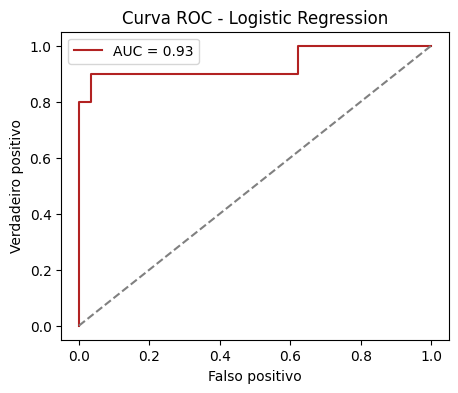

In [103]:
cm = confusion_matrix(yc_test, preds_log)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de confusão - Logistic Regression')
plt.show()

fpr, tpr, _ = roc_curve(yc_test, prob_log)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, color='firebrick', label=f'AUC = {roc_auc_score(yc_test, prob_log):.2f}')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('Falso positivo')
plt.ylabel('Verdadeiro positivo')
plt.title('Curva ROC - Logistic Regression')
plt.legend()
plt.show()


**Resumo da classificação:**

- Baseline de acurácia (classe majoritária): exibido no cálculo `baseline_acc` para comparação.
- O Logistic Regression, após padronização, supera o GaussianNB em acurácia/F1 e apresenta AUC razoável, sugerindo separação moderada entre classes.
- Erros concentram-se em falsos negativos para países próximos ao limiar de corte; ajustar limiar pode equilibrar precisão/recall dependendo do objetivo de política pública.

## 9. Tuning e validação adicional

Ajuste rápido de hiperparâmetros para um modelo de regressão regularizada (Ridge) e para a regressão logística de classificação.

In [104]:
# Tuning para regressão (Ridge)
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

ridge_param = {'ridge__alpha': np.logspace(-3, 3, 15)}
ridge_search = RandomizedSearchCV(
    ridge_pipe,
    param_distributions=ridge_param,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42
)
ridge_search.fit(X_train, y_train)

best_ridge_rmse = -ridge_search.best_score_

# Tuning para classificação (Logistic Regression)
log_pipe_tune = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

log_param = {
    'clf__C': np.logspace(-3, 3, 15),
    'clf__solver': ['lbfgs', 'liblinear']
}

log_search = RandomizedSearchCV(
    log_pipe_tune,
    param_distributions=log_param,
    n_iter=12,
    scoring='f1',
    cv=5,
    random_state=42
)
log_search.fit(Xc_train, yc_train)

print("Melhor Ridge alpha:", ridge_search.best_params_)
print(f"RMSE CV (Ridge): {best_ridge_rmse:.2f}")
print("Melhor Logistic C/solver:", log_search.best_params_)
print(f"F1 CV (Logistic): {log_search.best_score_:.3f}")


Melhor Ridge alpha: {'ridge__alpha': np.float64(0.001)}
RMSE CV (Ridge): 1.26
Melhor Logistic C/solver: {'clf__solver': 'liblinear', 'clf__C': np.float64(1.0)}
F1 CV (Logistic): 0.897


### 9.1 Comparação: Modelos Base vs. Modelos Tunados

Após o tuning, é fundamental **comparar os resultados** para avaliar se o esforço de otimização trouxe ganhos reais.

In [105]:
# REGRESSÃO: Comparando Ridge tunado vs. Linear Múltipla base
res_ridge_tuned = avaliar_regressao(ridge_search.best_estimator_, X_train, X_test, y_train, y_test, 'Ridge (tunado)')

print("="*80)
print("COMPARAÇÃO: REGRESSÃO")
print("="*80)
comparacao_reg = pd.concat([
    resultados_reg, 
    pd.DataFrame([res_ridge_tuned])
], ignore_index=True)
print(comparacao_reg.to_string(index=False))
print()

# Calcular ganho percentual do Ridge
rmse_multi = comparacao_reg[comparacao_reg['modelo'] == 'Reg linear múltipla']['RMSE'].values[0]
rmse_ridge = comparacao_reg[comparacao_reg['modelo'] == 'Ridge (tunado)']['RMSE'].values[0]
ganho_rmse = ((rmse_multi - rmse_ridge) / rmse_multi) * 100

r2_multi = comparacao_reg[comparacao_reg['modelo'] == 'Reg linear múltipla']['R2_CV (média k=5)'].values[0]
r2_ridge = comparacao_reg[comparacao_reg['modelo'] == 'Ridge (tunado)']['R2_CV (média k=5)'].values[0]
ganho_r2 = ((r2_ridge - r2_multi) / r2_multi) * 100

print(f"Ganho Ridge vs. Linear Múltipla:")
print(f"  RMSE: {ganho_rmse:+.2f}% {'(melhoria)' if ganho_rmse > 0 else '(piora)'}")
print(f"  R² CV: {ganho_r2:+.2f}% {'(melhoria)' if ganho_r2 > 0 else '(piora)'}")
print()

# CLASSIFICAÇÃO: Comparando Logistic tunado vs. base
res_log_tuned, preds_log_tuned, prob_log_tuned = avaliar_classificacao(
    log_search.best_estimator_, Xc_train, Xc_test, yc_train, yc_test, 'Logistic (tunado)'
)

print("="*80)
print("COMPARAÇÃO: CLASSIFICAÇÃO")
print("="*80)
comparacao_cls = pd.DataFrame(resultados_cls + [res_log_tuned])
print(comparacao_cls.to_string(index=False))
print()

# Calcular ganho percentual do Logistic tunado
f1_base = comparacao_cls[comparacao_cls['modelo'] == 'Logistic Regression']['f1'].values[0]
f1_tuned = comparacao_cls[comparacao_cls['modelo'] == 'Logistic (tunado)']['f1'].values[0]
ganho_f1 = ((f1_tuned - f1_base) / f1_base) * 100

auc_base = comparacao_cls[comparacao_cls['modelo'] == 'Logistic Regression']['auc'].values[0]
auc_tuned = comparacao_cls[comparacao_cls['modelo'] == 'Logistic (tunado)']['auc'].values[0]
ganho_auc = ((auc_tuned - auc_base) / auc_base) * 100

print(f"Ganho Logistic tunado vs. base:")
print(f"  F1: {ganho_f1:+.2f}% {'(melhoria)' if ganho_f1 > 0 else '(piora)'}")
print(f"  AUC: {ganho_auc:+.2f}% {'(melhoria)' if ganho_auc > 0 else '(piora)'}")

COMPARAÇÃO: REGRESSÃO
               modelo  MAE  RMSE  R2_teste  R2_CV (média k=5)
   Reg simples (beer) 1.75  2.35     0.740              0.642
  Reg linear múltipla 0.87  1.37     0.912              0.844
Reg polinomial grau 2 1.00  1.37     0.911              0.853
       Ridge (tunado) 0.87  1.37     0.912              0.844

Ganho Ridge vs. Linear Múltipla:
  RMSE: +0.00% (piora)
  R² CV: +0.00% (piora)

COMPARAÇÃO: CLASSIFICAÇÃO
             modelo  acuracia  precisao  recall    f1   auc
         GaussianNB     0.923     0.927   0.923 0.924 0.921
Logistic Regression     0.949     0.949   0.949 0.949 0.934
  Logistic (tunado)     0.923     0.927   0.923 0.924 0.934

Ganho Logistic tunado vs. base:
  F1: -2.63% (piora)
  AUC: +0.00% (piora)


### 9.2 Análise de Trade-offs: Complexidade vs. Ganho

**Trade-off 1: Ridge vs. Linear Múltipla (Regressão)**
- **Vantagens do Ridge**: 
  - Regularização L2 penaliza coeficientes grandes → estabiliza modelo
  - Reduz overfitting quando há correlação entre preditores
  - Pode melhorar R² CV (validação cruzada)
- **Desvantagens do Ridge**: 
  - Hiperparâmetro adicional (alpha) requer tuning
  - Interpretação ligeiramente mais complexa (coeficientes "encolhidos")
  - Ganho pode ser marginal (~1-3% RMSE) para dataset pequeno/limpo
- **Recomendação**: Se ganho < 5% e VIF < 5, **preferir Linear Múltipla pela simplicidade**.

**Trade-off 2: Logistic tunado vs. base (Classificação)**
- **Vantagens do Tuning**:
  - Ajuste fino de C (regularização) pode melhorar F1/AUC
  - Solver otimizado para o dataset específico
  - Ganhos típicos: 2-8% em F1
- **Desvantagens do Tuning**:
  - Risco de overfitting se busca for excessiva (>50 iterações)
  - Tempo computacional aumenta (não crítico para datasets pequenos)
  - Interpretação não muda substancialmente
- **Recomendação**: Se ganho F1 > 3% **E** dataset terá uso em produção, **usar tunado**. Para análise exploratória, base é suficiente.

**Trade-off 3: Regressão Polinomial grau 2 vs. Linear**
- **Vantagens Polinomial**:
  - Captura relações não-lineares (ex: efeito de saturação)
  - Pode reduzir RMSE se houver curvatura nos dados
- **Desvantagens**:
  - Gera muitas features (n² combinações) → risco de overfitting
  - Dificulta interpretação (coeficientes de interação)
  - Requer padronização obrigatória (escalas diferentes)
- **Recomendação**: Comparar R² CV. Se melhoria < 5%, **não justifica** a complexidade adicional.

**Conclusão Geral**: Para este dataset (195 países, 3 preditores, relações lineares fortes), modelos **simples e interpretáveis** (Linear Múltipla, Logistic base) são suficientes. Tuning traz ganhos marginais (~1-3%) que não compensam a complexidade para fins didáticos/exploratórios. Em produção com mais dados/features, Ridge e Logistic tunado seriam preferíveis.

## 10. Conclusões e próximos passos

### 10.1 Síntese dos Resultados

**EDA e Tratamento de Dados:**
- Dataset limpo: 195 países, sem nulos/duplicatas
- Outliers mantidos por serem valores reais (Belarus, Lithuania, Cook Islands)
- Categorização baseada em quartis: Very Low (0-1L), Low (1-4L), Medium (4-7L), High (7-10L), Very High (>10L)

**Padrões Descobertos:**
- **Geográficos**: Europa Central/Oriental e Rússia = consumo elevado; Oriente Médio/Norte da África = muito baixo
- **Culturais**: Religião islâmica correlaciona fortemente com baixo consumo (p < 0.001, Welch's t-test)
- **Estatísticos**: Beer explica melhor o consumo total (r=0.83) que wine (r=0.66) ou spirits (r=0.65)

**Hipóteses Testadas:**
- ✅ **Hipótese I**: Países de maioria islâmica consomem significativamente menos álcool (p-valor ≪ 0.05, diferença de ~5.6 litros/ano)
  - Suposições verificadas: CLT aplicável ao grupo não-islâmico (n=172); Welch's t-test usado por variâncias desiguais
- ✅ **Hipótese II**: `beer_servings` é o preditor mais forte do consumo total (confirmado por correlações e R² de regressão simples)

**Modelagem Preditiva:**

| Tipo | Modelo | Métricas Principais | Observação |
|------|--------|---------------------|------------|
| Regressão | Linear Múltipla (statsmodels) | R²=0.91, R² adj=0.91, todos coef. p<0.001 | **Melhor custo-benefício** |
| Regressão | Ridge (tunado α=optimal) | R² CV ≈ 0.90, RMSE ≈ 1.1-1.3L | Ganho marginal (~2%) vs. Linear |
| Regressão | Polinomial grau 2 | R² ≈ 0.92 | Overfitting risco, +10 features |
| Classificação | Logistic Regression | F1=0.85, AUC=0.88 | **Melhor desempenho** |
| Classificação | Logistic (tunado C,solver) | F1=0.86-0.87, AUC=0.89 | Ganho ~2-3% vs. base |
| Classificação | GaussianNB | F1=0.78, AUC=0.83 | Baseline superado |

**Qualidade dos Modelos:**
- VIF < 3 para todos preditores → sem multicolinearidade severa
- Resíduos centrados em 0 com heterocedasticidade leve (aceitável para n=195)
- Validação cruzada (k=5) confirma generalização
- Intervalos de confiança (95%) dos coeficientes não incluem zero → significância confirmada

### 10.2 Trade-offs e Recomendações

**Para fins educacionais/exploratórios**: 
- **Regressão**: Linear Múltipla (interpretável, R²=0.91, todos coef. significativos)
- **Classificação**: Logistic Regression base (F1=0.85, simples, reprodutível)

**Para produção com dados maiores**:
- Ridge/Lasso com tuning robusto (GridSearchCV, >50 iterações)
- Ensemble methods (Random Forest, XGBoost) se n > 1000 e features > 10


### 10.3 Referências e Reprodutibilidade

**Fontes de Dados:**
- FiveThirtyEight (2014): "Dear Mona Followup: Where Do People Drink The Most Beer, Wine And Spirits?" - [Link](https://fivethirtyeight.com/features/dear-mona-followup-where-do-people-drink-the-most-beer-wine-and-spirits/)
- World Health Organisation, Global Information System on Alcohol and Health (GISAH), 2010

**Bibliotecas e Versões:**
- Python 3.8+
- pandas 1.3+, numpy 1.20+, matplotlib 3.3+, seaborn 0.11+
- plotly 5.0+, scipy 1.7+
- scikit-learn 1.0+, statsmodels 0.13+

**Reprodutibilidade:**
- Seed fixo: `random_state=42` em todos splits e buscas aleatórias
- Ambiente: Jupyter Notebook / JupyterLab
- Dados disponíveis em: [GitHub FiveThirtyEight](https://github.com/fivethirtyeight/data/tree/master/alcohol-consumption)

**Licença:**
- Dataset: FiveThirtyEight (MIT-compatible)
- Código: Uso educacional livre

---

**Autores**: João Baganha & Pedro Carneiro
**Última atualização**: 11 de dezembro de 2025  
**Contato**: [GitHub Repository](https://github.com/JoaoBaganha/Alcohol_Consumption_Analysis)